# Task15 集成学习案例二 （蒸汽量预测）

## 1 主要思路

### 1.1 基本思路
1. 导入数据集，标记数据来源，并合并训练集和测试集
2. 探索数据分布，目的是找出相关性低的特征，降维
  - 采用核密度估计对特征值进行分析
  - 删除分布不均的特征
  - 查看特征之间的相关性，并删除相关性低的特征
  - 对数据归一化
3. 特征工程，目的是对各列（特征列和目标列）进行正态化
  - 对各特征列比较Box-Cox变换前后，并进行变换
  - 对目标列进行正态分布检验，并使用指数变换
4. 模型构建并使用集成学习
  - 构建训练集、验证集和测试集
  - 编写RMES、MES评价函数
  - 使用Z检验寻找并删除离群点
  - 训练模型，并进行模型融合
5. 预测结果并保存

### 1.2 评价指标
最终的评价指标为均方误差MSE，即：
$$Score = \frac{1}{n} \sum_1 ^n (y_i - y ^*)^2$$

## 2 Baseline代码实战

### 2.1 导入package

In [1]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

### 2.2 加载数据

In [2]:
data_train = pd.read_csv('../assets/ch06/case02/data/train.txt',sep = '\t')
data_test = pd.read_csv('../assets/ch06/case02/data/test.txt',sep = '\t')

In [3]:
# 标记数据来源
data_train["origin"] = "train"
data_test["origin"] = "test"
# 合并训练集和测试集
data_all = pd.concat([data_train, data_test], axis=0, ignore_index=True)
# 显示前5条数据
data_all.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V30,V31,V32,V33,V34,V35,V36,V37,target,origin
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175,train
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676,train
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633,train
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206,train
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384,train


### 2.3 探索数据分布

#### 2.3.1 采用核密度估计对所有的特征值进行分析
由于是传感器的数据（连续变量），所以使用 kdeplot(核密度估计图) 进行数据的初步分析，即EDA。  
核密度估计(kernel density estimation)是在概率论中用来估计未知的密度函数，属于非参数检验方法之一。通过核密度估计图可以比较直观的看出数据样本本身的分布特征。

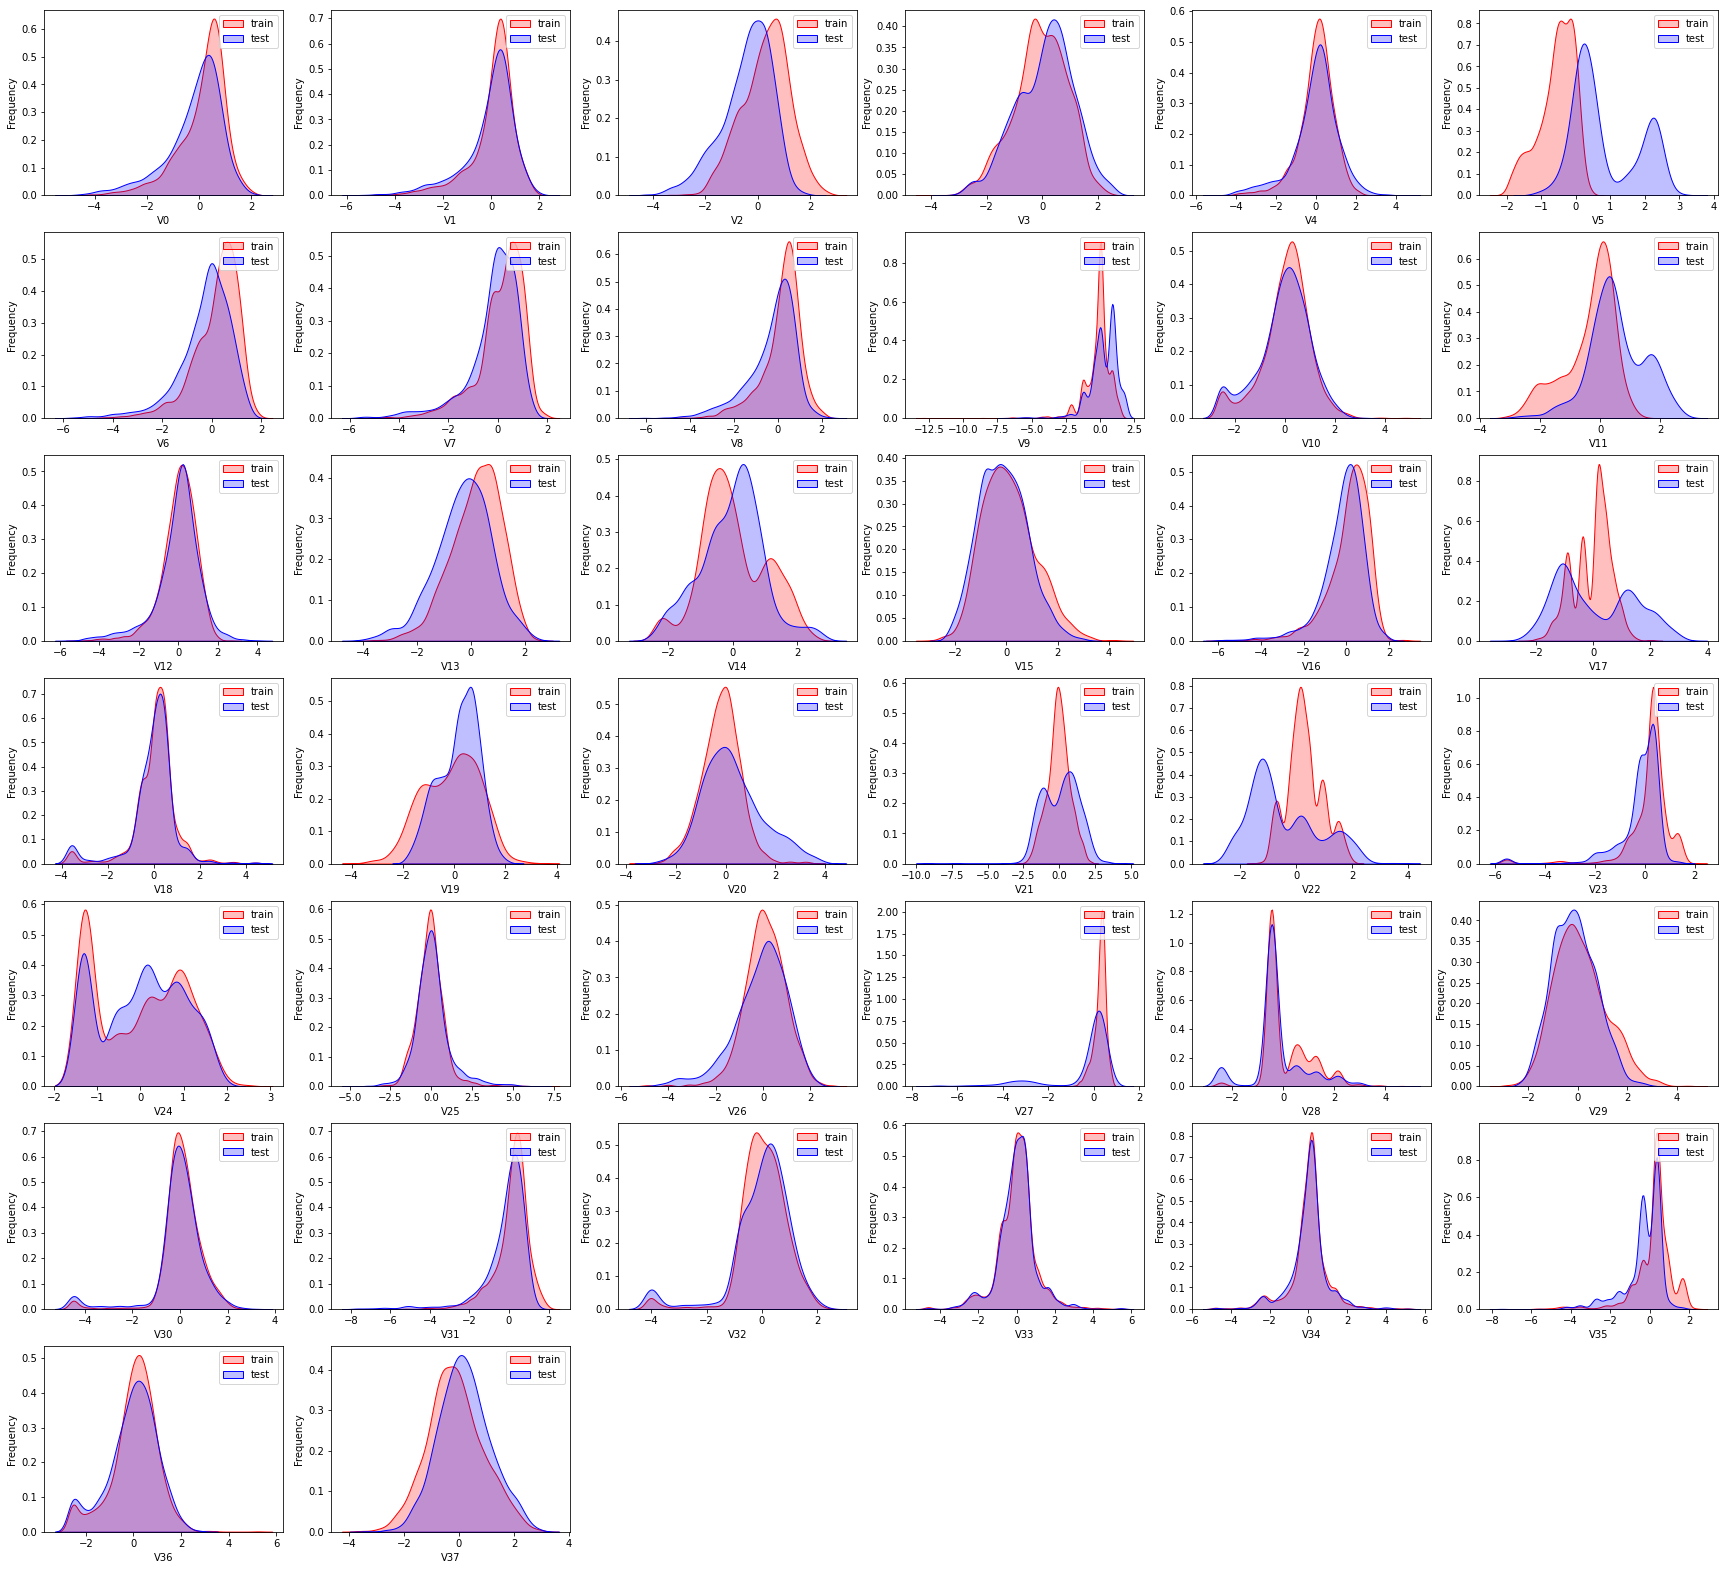

In [4]:
fcols = 6
frows = len(data_all.columns) // fcols + 1
plt.figure(figsize=(5*fcols, 4*frows))
i = 0

for column in data_all.columns[0:-2]:
    i += 1
    # 在相应的位置展示分布图
    plt.subplot(frows, fcols, i)
    # 训练集的数据分布标为红色
    g = sns.kdeplot(
        data_all[column][(data_all["origin"] == "train")], color="Red", shade=True)
    # 测试集的数据分布标为蓝色
    g = sns.kdeplot(data_all[column][(
        data_all["origin"] == "test")], ax=g, color="Blue", shade=True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train", "test"])

从以上的图中可以看出特征"V5","V9","V11","V17","V22","V28"中训练集数据分布和测试集数据分布不均，所以我们删除这些特征数据

#### 2.3.2 删除分布不均的特征

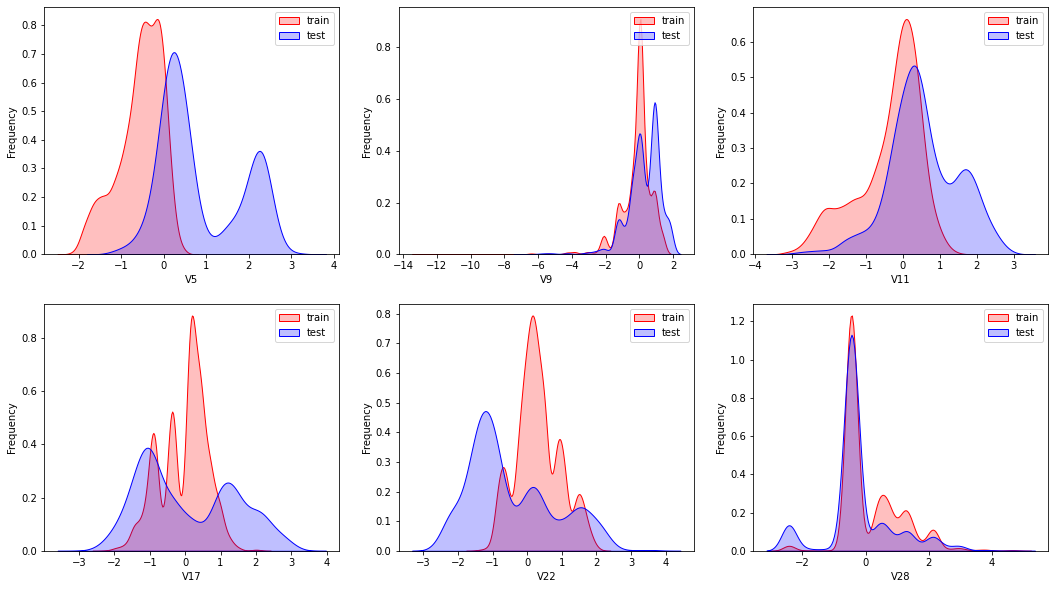

In [5]:
del_columns = ["V5", "V9", "V11", "V17", "V22", "V28"]
fcols = 3
frows = len(del_columns) // fcols
plt.figure(figsize=(6*fcols, 5*frows))
i = 0

for column in del_columns:
    i += 1
    plt.subplot(frows, fcols, i)
    g = sns.kdeplot(data_all[column][(data_all["origin"] == "train")], color="Red", shade = True)
    g = sns.kdeplot(data_all[column][(data_all["origin"] == "test")], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])

In [6]:
# 删除分布不均的特征
data_all.drop(del_columns, axis=1, inplace=True)

#### 2.3.3 查看特征之间的相关性（相关程度）
通过corr计算特征之间的相关性，数值越大，说明线性相关性越高；采用heatmap热力图展示各特征值与target的相关性。

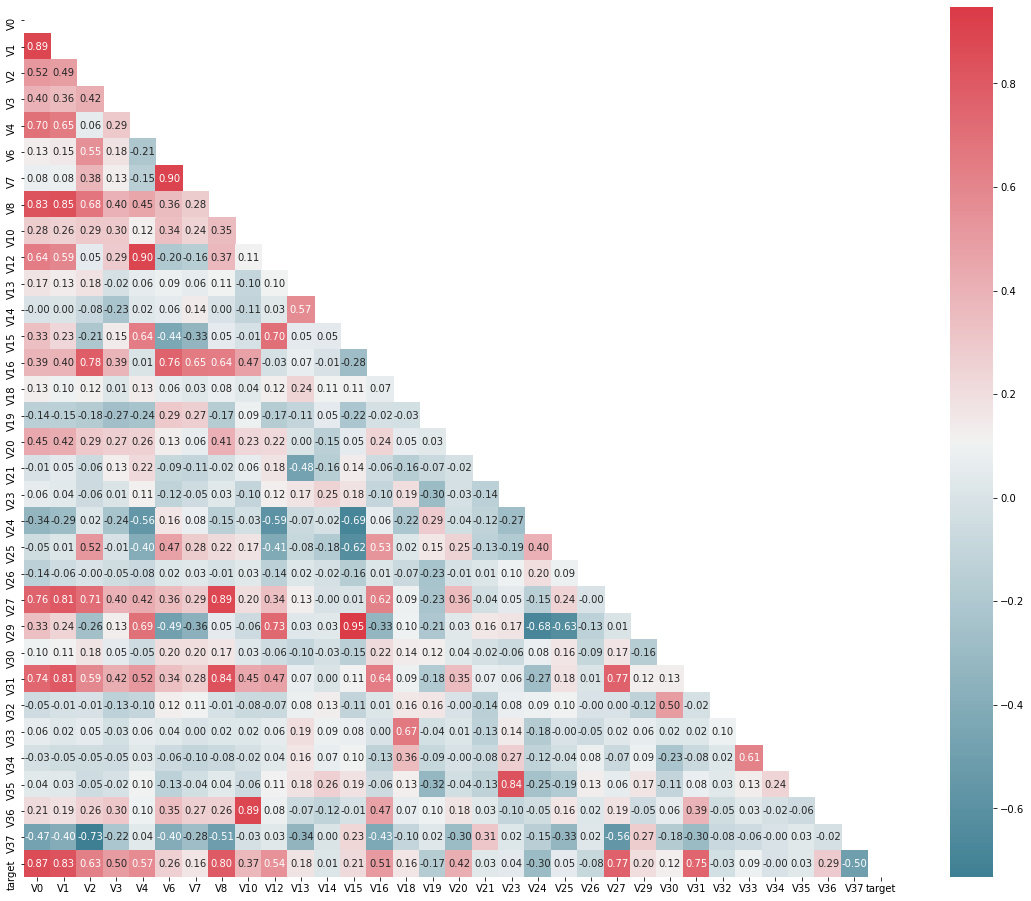

In [7]:
# 删除origin标识，得到原始数据，用于计算相关系数矩阵
data_train_origin=data_all[data_all["origin"]=="train"].drop("origin",axis=1)
# 指定绘图对象宽度和高度
plt.figure(figsize=(20, 16))
# 特征列
cols = data_train_origin.columns.tolist()
# 相关系数矩阵，即计算任意两个变量之间的相关系数（相似度）
mcorr = data_train_origin[cols].corr(method="spearman")  
# 构造与mcorr同维数矩阵，数据类型为bool型，用于在heatmap中传入mask
mask = np.zeros_like(mcorr, dtype=np.bool)  
# 对角线上方为True，用于绘制下三角图
mask[np.triu_indices_from(mask)] = True
# 返回matplotlib colormap对象，调色板
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
# 热力图，用于展示个特征的相似度
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

#### 2.3.4 删除相关性低的特征列
对数据进一步降维，将相关性的绝对值小于阈值（设置为0.1）的特征列删除

In [8]:
# 设置阈值为0.1
threshold = 0.1
# 计算相关系数矩阵，并对相关性取绝对值
corr_matrix = data_train_origin.corr().abs()
# 取出要删除的特征列
drop_col = corr_matrix[corr_matrix["target"] < threshold].index
# 删除相关性低的特征列
data_all.drop(drop_col, axis=1, inplace=True)

#### 2.3.5 对数据进行归一化

In [9]:
cols_numeric=list(data_all.columns)
cols_numeric.remove("origin")
df = data_all[data_all.columns[0:-2]]
# 进行归一化
df = (df-df.min())/(df.max()-df.min())
df.describe()

,V0,V1,V2,V3,V4,V6,V7,V8,V10,V12,...,V20,V23,V24,V27,V29,V30,V31,V35,V36,V37
count,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,...,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000,4813.000000
mean,0.694172,0.721357,0.602300,0.603139,0.523743,0.748823,0.745740,0.715607,0.348518,0.578507,...,0.456147,0.744438,0.356712,0.881401,0.388683,0.589459,0.792709,0.762873,0.332385,0.545795
std,0.144198,0.131443,0.140628,0.152462,0.106430,0.132560,0.132577,0.118105,0.134882,0.105088,...,0.134083,0.134085,0.265512,0.128221,0.133475,0.130786,0.102976,0.102037,0.127456,0.150356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.626676,0.679416,0.514414,0.503888,0.478182,0.683324,0.696938,0.664934,0.284327,0.532892,...,0.370475,0.719362,0.040616,0.888575,0.292445,0.550092,0.761816,0.727273,0.270584,0.445647
50%,0.729488,0.752497,0.617072,0.614270,0.535866,0.774125,0.771974,0.742884,0.366469,0.591635,...,0.447305,0.788817,0.381736,0.916015,0.375734,0.594428,0.815055,0.800020,0.347056,0.539317
75%,0.790195,0.799553,0.700464,0.710474,0.585036,0.842259,0.836405,0.790835,0.432965,0.641971,...,0.522660,0.792706,0.574728,0.932555,0.471837,0.650798,0.852229,0.800020,0.414861,0.643061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# 原数据拼接
data_all = pd.concat(
    [df, data_all['target'], data_all['origin']], axis=1, ignore_index=False)

### 2.4 特征工程

绘图显示Box-Cox变换对数据分布影响，Box-Cox用于连续的响应变量不满足正态分布的情况。在进行Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。

对于quantitle-quantile(q-q)图，可参考： https://blog.csdn.net/u012193416/article/details/83210790

#### 2.4.1 对各特征数据绘制使用Box-Cox前后的对比图

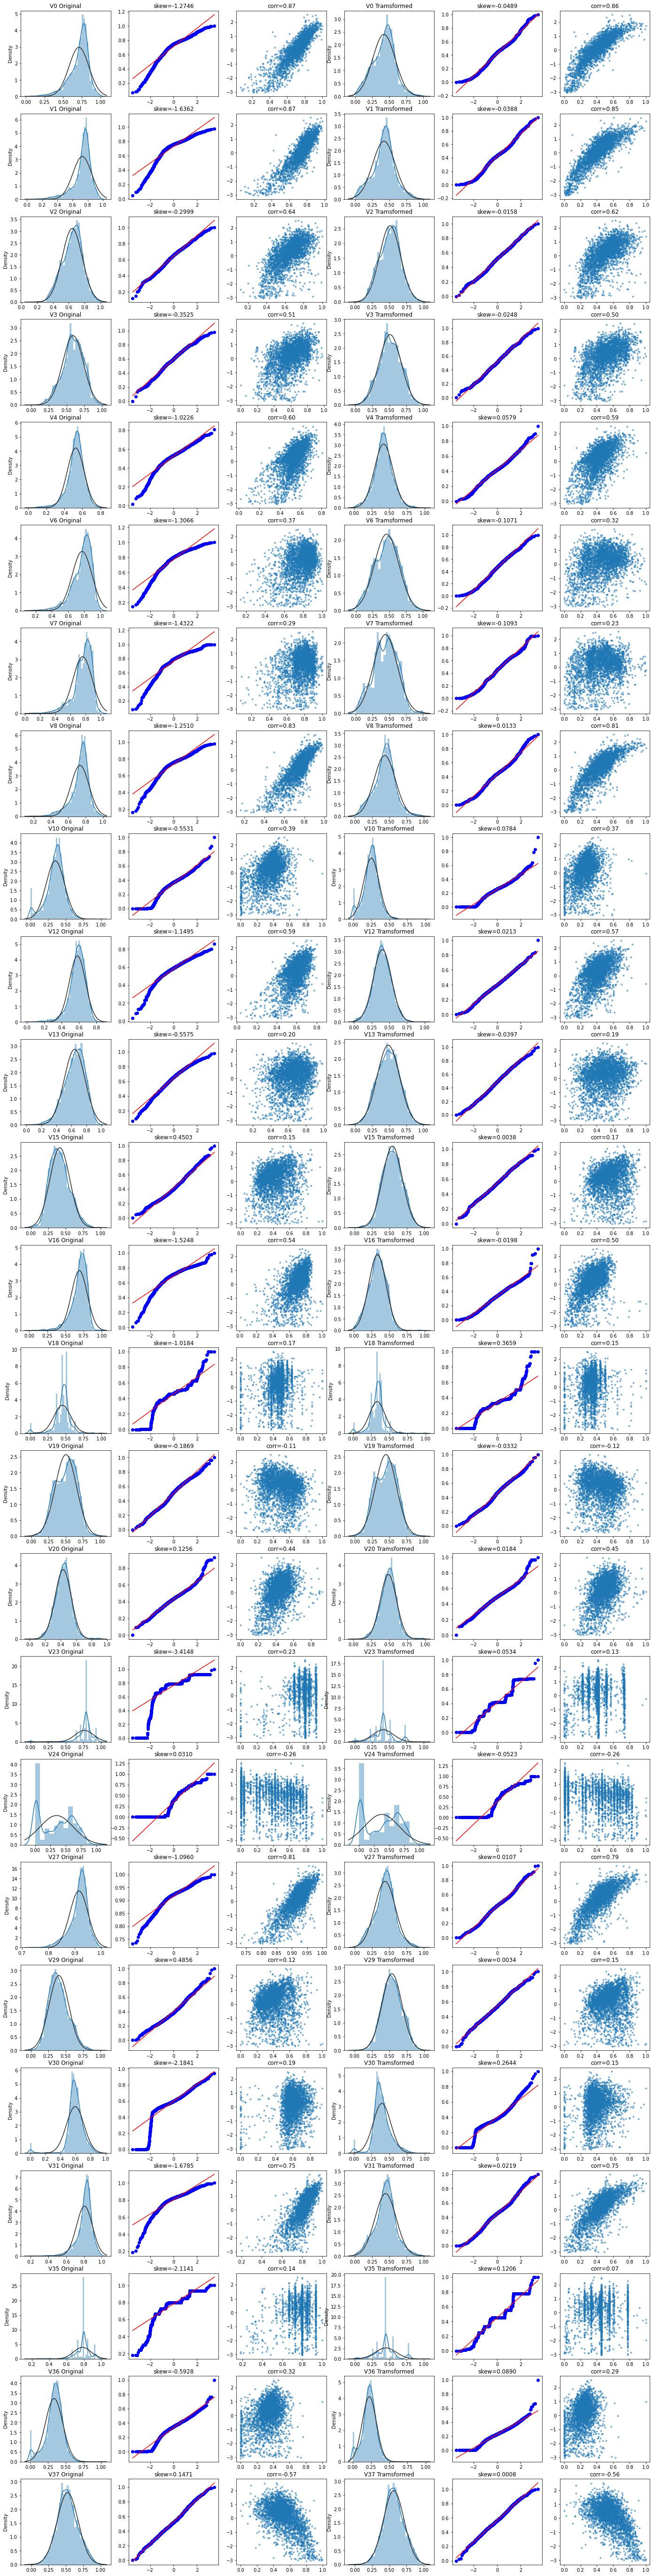

In [11]:
fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols, 4*frows))
i = 0

for var in cols_numeric:
    if var != 'target':
        # 仅留下训练集数据
        dat = data_all[[var, 'target']].dropna()
        
        # 不使用boxcox之前
        # 绘制直方图和核密度估计图的合成图，并拟合标准正态分布
        i += 1
        plt.subplot(frows, fcols, i)
        sns.distplot(dat[var], fit=stats.norm)
        plt.title(var+' Original')
        plt.xlabel('')
        
        # 绘制q-q图，用于检测特征数据是否符合正态分布
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot=plt)
        # 计算特征数据与正态分布的偏离度
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        # 绘制数据点图，用于观察特征数据与目标列数据
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', alpha=0.5)
        plt.title(
            'corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
        
        # 使用boxcox进行数据分布正态化
        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        # 进行归一化
        trans_var = (trans_var-trans_var.min())/(trans_var.max()-trans_var.min())
        # 绘制直方图和核密度估计图的合成图，并拟合标准正态分布
        sns.distplot(trans_var, fit=stats.norm)
        plt.title(var+' Tramsformed')
        plt.xlabel('')

        i += 1
        plt.subplot(frows, fcols, i)
        # 绘制q-q图，用于检测boxcox转换之后的数据是否符合正态分布
        _ = stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        # 绘制数据点图，用于观察boxcox转换之后的数据数据与目标列数据
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(trans_var, dat['target'], '.', alpha=0.5)
        plt.title(
            'corr='+'{:.2f}'.format(np.corrcoef(trans_var, dat['target'])[0][1]))

#### 2.4.2 对各特征列数据进行Box-Cox变换

In [12]:
# 进行Box-Cox变换
cols_transform = data_all.columns[0:-2]
for col in cols_transform:
    # transform column
    data_all.loc[:, col], _ = stats.boxcox(data_all.loc[:, col]+1)

#### 2.4.3 对目标列数据进行正态分布检验

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


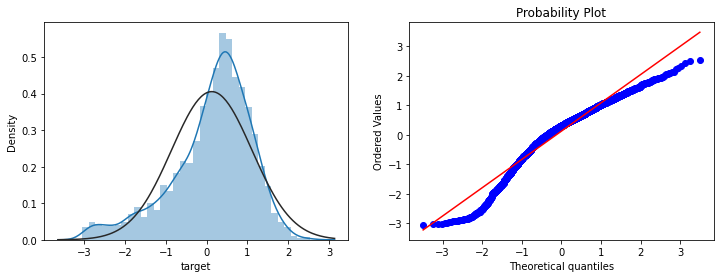

In [13]:
print(data_all.target.describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# 绘制直方图和核密度估计图的合成图，并拟合标准正态分布
sns.distplot(data_all.target.dropna(), fit=stats.norm)
plt.subplot(1, 2, 2)
# 绘制q-q图，用于检测特征数据是否符合正态分布
_ = stats.probplot(data_all.target.dropna(), plot=plt)

#### 2.4.5 对目标列数据使用对数变换

使用指数变换target目标值提升特征数据的正态性，可参考：https://www.zhihu.com/question/22012482

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


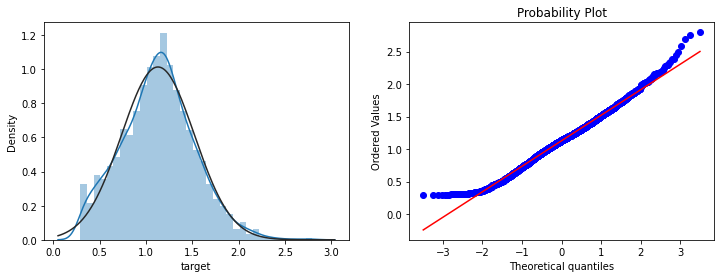

In [14]:
sp = data_train.target
# 使用指数变换，提升target目标列数据的正态性
data_train.target1 = np.power(1.5, sp)
print(data_train.target1.describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(data_train.target1.dropna(), fit=stats.norm)
plt.subplot(1, 2, 2)
_ = stats.probplot(data_train.target1.dropna(), plot=plt)

### 2.5 模型构建以及集成学习

#### 2.5.1 构建训练集和测试集

In [15]:
def get_training_data():
    from sklearn.model_selection import train_test_split
    # 取出训练集数据
    df_train = data_all[data_all["origin"] == "train"]
    df_train["label"] = data_train.target1

    y = df_train.target
    # 删除非特征列
    X = df_train.drop(["origin", "target", "label"], axis=1)
    # 划分训练集和验证集数据
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.3, random_state=100)
    return X_train, X_valid, y_train, y_valid


def get_test_data():
    # 获取测试集数据
    df_test = data_all[data_all["origin"] == "test"].reset_index(drop=True)
    return df_test.drop(["origin", "target"], axis=1)

#### 2.5.2 编写rmse、mse的评价函数

In [16]:
from sklearn.metrics import make_scorer


def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)
    n = len(y_pred)
    return np.sqrt(sum_sq/n)


def mse(y_ture, y_pred):
    return mean_squared_error(y_ture, y_pred)


# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 输入的score_func为记分函数时，该值为True（默认值）；输入函数为损失函数时，该值为False
mse_scorer = make_scorer(mse, greater_is_better=False)

#### 2.5.3 寻找并删除离群值

In [17]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # 训练模型
    model.fit(X, y)
    # 预测y值
    y_pred = pd.Series(model.predict(X), index=y.index)

    # 计算残差
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # 使用正态偏差Z检验，计算偏差
    z = (resid - mean_resid)/std_resid
    # 假如偏差大于3，即为离群点
    outliers = z[abs(z) > sigma].index

    print('R2=', model.score(X, y))
    print('rmse=', rmse(y, y_pred))
    print("mse=", mean_squared_error(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')

    print(len(outliers), 'outliers:')
    print(outliers.tolist())

    # 绘制离群点图
    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')

    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y-y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers]-y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')

    return outliers

R2= 0.8766692297367809
rmse= 0.3490086775113313
mse= 0.12180705697820839
---------------------------------------
mean of residuals: -2.208360494306348e-16
std of residuals: 0.34909505510886996
---------------------------------------
22 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 884, 2696, 2668, 1310, 1901, 1458, 2769, 2002, 2669, 1972]


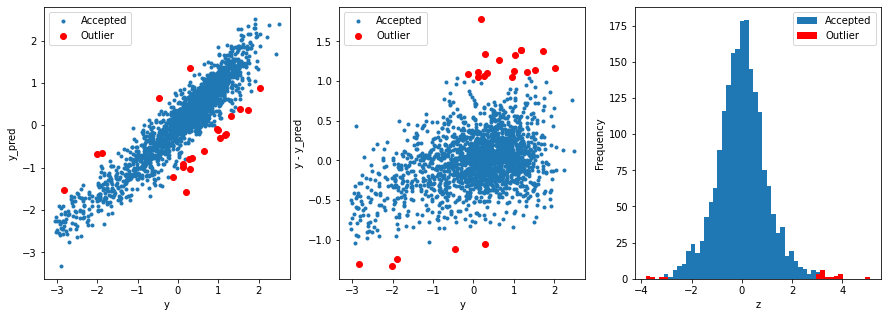

In [18]:
# get training data
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

# 删除离群点
outliers = find_outliers(Ridge(), X_train, y_train)
X_outliers = X_train.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X_train.drop(outliers)
y_t = y_train.drop(outliers)

从图中可看出，有22个标红色的离群点。

#### 2.5.4 训练模型

In [19]:
def get_trainning_data_omitoutliers():
    # 获取训练数据省略异常值
    y = y_t.copy()
    X = X_t.copy()
    return X, y

In [20]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # 获取数据
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        
    # 交叉验证
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # 使用网格搜索最佳参数
    if len(param_grid)>0:
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # 训练模型
        gsearch.fit(X,y)

        # 得到最佳模型
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # 得到交叉验证评价指标
        grid_results = pd.DataFrame(gsearch.cv_results_)
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # 不使用网格搜索，仅使用交叉验证 
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # 合并数据
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # 预测
    y_pred = model.predict(X)
    
    # 模型性能的统计数据        
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    return model, cv_score, grid_results

In [21]:
# 定义训练变量存储数据
opt_models = dict()
# 存储模型的性能（均值、标准差）
score_models = pd.DataFrame(columns=['mean','std'])
splits=5
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Ridge(alpha=0.25)
----------------------
score= 0.8926884445023296
rmse= 0.3246640786362218
mse= 0.1054067639567068
cross_val: mean= 0.10921408260791286 , std= 0.009360597609668288


Text(0, 0.5, 'score')

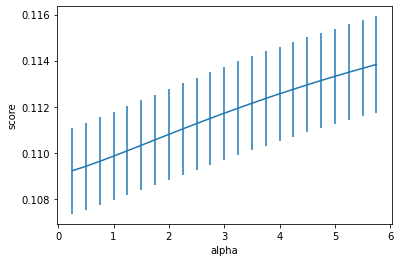

In [22]:
# 使用Ridge模型，可使用集成学习，融合更多的模型
model = 'Ridge'
opt_models[model] = Ridge()
alph_range = np.arange(0.25, 6, 0.25)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid,
                                                        splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

# 绘制误差条图
plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

#### 2.5.5 预测结果并保存

In [23]:
# 预测函数
def model_predict(test_data, test_y=[]):
    i = 0
    y_predict_total = np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model != "LinearSVR" and model != "KNeighbors":
            y_predict = opt_models[model].predict(test_data)
            y_predict_total += y_predict
            i += 1
        if len(test_y) > 0:
            print("{}_mse:".format(model), mean_squared_error(y_predict, test_y))
    y_predict_mean = np.round(y_predict_total/i, 6)
    if len(test_y) > 0:
        print("mean_mse:", mean_squared_error(y_predict_mean, test_y))
    else:
        y_predict_mean = pd.Series(y_predict_mean)
        return y_predict_mean

In [24]:
y_ = model_predict(test)
y_.to_csv('predict.txt',header = None,index = False)